In [1]:
'''Import basic modules'''
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression, SGDClassifier

'''import visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

import matplotlib.gridspec as gridspec

'''Plotly visualization .'''
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

In [2]:
# Load data
train = pd.read_csv('../Desktop/android_bids_us.csv')
print(train.shape)

(3148828, 12)


In [ ]:
from pandas_profiling import ProfileReport
import matplotlib.gridspec as gridspec
profile = ProfileReport(train, minimal=True)
profile

In [3]:
#Variable Description
def description(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
    return summary
bold('**Variable Description of  train Data:**')
description(train)

**Variable Description of  train Data:**

Dataset Shape: (3148828, 12)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,bidid,object,0,2936921,87b0108c-6e9f-4783-8b80-8dd5aa3529a8,9284441f-a6ea-4698-9017-86436b92d416,7e4779c2-f757-4324-8c2a-138b558b5a54
1,utc_time,int64,0,3147513,1536444331894,1536444363932,1536444386908
2,app_id,object,0,14869,com.OppanaGames.CarSim,com.mobilityware.CrownSolitaire,com.kuttigames.tenkyurollball
3,user_state,object,0,51,TX,TX,LA
4,user_isp,object,39,3449,AT&T Wireless,T-Mobile USA,AT&T Wireless
5,device_maker,object,964004,265,NaN,NaN,NaN
6,device_model,object,963858,2342,NaN,NaN,NaN
7,device_osv,object,0,20,7.0,7.0,7.1.1
8,device_height,int64,0,308,720,1280,720
9,device_width,int64,0,248,1280,720,1280


In [4]:
# Replacing missing values by the most repeat data(mod)e in the colomns 

def replace_nan(data):
    for column in data.columns:
        if data[column].isna().sum() > 0:
            data[column] = data[column].fillna(data[column].mode()[0])


replace_nan(train)

In [5]:
#Delete Bidid which have the most cardinality (see complete panda profiling-EDA) and marketplace in which the value is constant
train.drop('bidid',axis=1,inplace=True)
train.drop('marketplace',axis=1,inplace=True)

In [6]:
# A quick descriptions of the missing values
description(train)

Dataset Shape: (3148828, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,utc_time,int64,0,3147513,1536444331894,1536444363932,1536444386908
1,app_id,object,0,14869,com.OppanaGames.CarSim,com.mobilityware.CrownSolitaire,com.kuttigames.tenkyurollball
2,user_state,object,0,51,TX,TX,LA
3,user_isp,object,0,3449,AT&T Wireless,T-Mobile USA,AT&T Wireless
4,device_maker,object,0,265,Samsung,Samsung,Samsung
5,device_model,object,0,2342,LM-X210(G),LM-X210(G),LM-X210(G)
6,device_osv,object,0,20,7.0,7.0,7.1.1
7,device_height,int64,0,308,720,1280,720
8,device_width,int64,0,248,1280,720,1280
9,click,int64,0,2,0,0,0


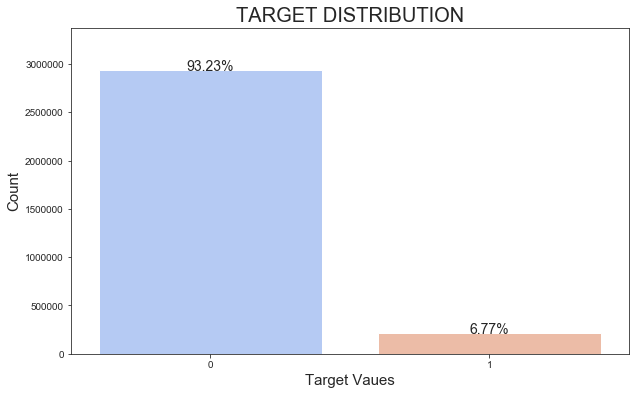

In [7]:
# A clear histogram representation of the numbers of clicks, 6% click on the advertize againt 94% non click.
total = len(train)
plt.figure(figsize=(10,6))

g = sns.countplot(x='click', data=train, palette='coolwarm')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

In [8]:
# make dummies variables for categorical colomns 
maker = pd.get_dummies(train.device_maker , prefix='device_maker')
dev_osv = pd.get_dummies(train.device_osv , prefix='device_osv')
states = pd.get_dummies(train.user_state , prefix='user_state')

In [9]:
#join new dummies variables and delete old variables 
train = train.join(dev_osv)
train.drop(['device_osv'], axis=1, inplace=True)
train = train.join(states)
train.drop(['user_state'], axis=1, inplace=True)
train = train.join(maker)
train.drop(['device_maker'], axis=1, inplace=True)

In [10]:
# Encode variables as categories
train["app_id"] = train["app_id"].astype('category')
train["user_isp"] = train["user_isp"].astype('category')
train["device_model"] = train["device_model"].astype('category')


In [11]:
#Check the change 
train.dtypes

utc_time                                                      int64
app_id                                                     category
user_isp                                                   category
device_model                                               category
device_height                                                 int64
device_width                                                  int64
click                                                         int64
device_osv_4.4.4 KitKat Os For 9inch QuadCore Tablet Pc       uint8
device_osv_5.0 by mrkindaiji                                  uint8
device_osv_6.0                                                uint8
device_osv_6.0.1                                              uint8
device_osv_6.1                                                uint8
device_osv_7.0                                                uint8
device_osv_7.0.1                                              uint8
device_osv_7.1                                  

In [12]:
#Encode others variables using encode categories and joins them to the dataframe
train["app_id_cat"] = train["app_id"].cat.codes
train["isp"] = train["user_isp"].cat.codes
train["dev_mod"] = train["device_model"].cat.codes

In [13]:
#Delete old variables 
del train['device_model']
del train['app_id']
del train['user_isp']

In [14]:
#Check the changes
train.dtypes

utc_time                                                   int64
device_height                                              int64
device_width                                               int64
click                                                      int64
device_osv_4.4.4 KitKat Os For 9inch QuadCore Tablet Pc    uint8
device_osv_5.0 by mrkindaiji                               uint8
device_osv_6.0                                             uint8
device_osv_6.0.1                                           uint8
device_osv_6.1                                             uint8
device_osv_7.0                                             uint8
device_osv_7.0.1                                           uint8
device_osv_7.1                                             uint8
device_osv_7.1.1                                           uint8
device_osv_7.1.2                                           uint8
device_osv_8.0                                             uint8
device_osv_8.0.0         

In [37]:
#observe the finale dataframe with 343 colomns.
train.head()
list(train.columns.values)

['utc_time',
 'device_height',
 'device_width',
 'click',
 'device_osv_4.4.4 KitKat Os For 9inch QuadCore Tablet Pc',
 'device_osv_5.0 by mrkindaiji',
 'device_osv_6.0',
 'device_osv_6.0.1',
 'device_osv_6.1',
 'device_osv_7.0',
 'device_osv_7.0.1',
 'device_osv_7.1',
 'device_osv_7.1.1',
 'device_osv_7.1.2',
 'device_osv_8.0',
 'device_osv_8.0.0',
 'device_osv_8.0.1',
 'device_osv_8.1.0',
 'device_osv_9',
 'device_osv_CONTIXO-LA703-20180915-v1.0',
 'device_osv_M',
 'device_osv_O',
 'device_osv_P',
 'device_osv_unknown',
 'user_state_AK',
 'user_state_AL',
 'user_state_AR',
 'user_state_AZ',
 'user_state_CA',
 'user_state_CO',
 'user_state_CT',
 'user_state_DC',
 'user_state_DE',
 'user_state_FL',
 'user_state_GA',
 'user_state_HI',
 'user_state_IA',
 'user_state_ID',
 'user_state_IL',
 'user_state_IN',
 'user_state_KS',
 'user_state_KY',
 'user_state_LA',
 'user_state_MA',
 'user_state_MD',
 'user_state_ME',
 'user_state_MI',
 'user_state_MN',
 'user_state_MO',
 'user_state_MS',
 'use

In [27]:
#Define variables X train features and y the target label I used the first 5 variables to reduce model running time 
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier

# Create X

features = ['app_id_cat','isp','dev_mod']
X = train[features]
y = train.click
print(X)
print(y)

print(train.shape)

         app_id_cat   isp  dev_mod
0              1276    50      897
1              8502  2713      897
2              7607    50      897
3             12597   659      897
4              7636    48      897
5              7359  2713      897
6             11012  2581      897
7               259  2598      897
8              4532  2581      897
9              4553   659      897
10             7688  2581      897
11             9516  2581      897
12            12058  2713      897
13             1132    50      897
14             5993   659      897
15            12190   659      897
16             7636    48      897
17            12190  2713      897
18             4310  2713      897
19              376   659      897
20             6564  2713      897
21            11189  2670      897
22             2982   429      897
23            12014   659      897
24            11189  3176      897
25             8502  2598      897
26            12058   729      897
27            11266 

[0.63211773 0.0973673  0.27051497]


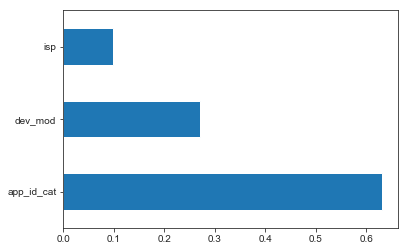

In [28]:
#use inbuilt class feature_importances of tree based classifiers , we observe app_id_cat,isp and dev_mod are the most important parameters.
#Device width and height seem less important (<0.03) so we delete them from the selections.
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [29]:
# Split into validation and training data but not randomly otherwise we can't control precisely the numbers of click vs unclick in each group.

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3,  
                                                    shuffle='False')

In [30]:
# Specify Model I did a pipeline using azure machine learning studio to check the best model, the best model is binary logistic regression
train_model = LogisticRegression(solver = "lbfgs") 

In [31]:
# Fit Model
train_model.fit(train_X, train_y)
train_model.fit(X,y)
train_score=train_model.score(train_X, train_y)

In [32]:
#train the model
train_model.fit(train_X, train_y)
preds_val_XG = train_model.predict(val_X)
print(preds_val_XG)

[0 0 0 ... 0 0 0]


In [33]:
# Make validation predictions and calculate mean absolute error
val_predictions = train_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print(val_mae)

0.06750973112764636


In [34]:
#Make train score in % 
train_score=train_model.score(train_X, train_y)


In [35]:
print (train_score)


0.9322078651506979


In [43]:
#In order to check the results we need to do a confusion matrix in order to find essential performance metrics.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, val_predictions)
print(cm)

[[880876      0]
 [ 63773      0]]


In [51]:
#From these results True positif = 880876 and False positif = 63773 we can build our classification report 
print ('\n*Classification Report:\n',classification_report(val_y, val_predictions))



*Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97    880876
           1       0.00      0.00      0.00     63773

    accuracy                           0.93    944649
   macro avg       0.47      0.50      0.48    944649
weighted avg       0.87      0.93      0.90    944649

